<a href="https://colab.research.google.com/github/oimartin/Predicting_House_Prices/blob/main/predicting_home_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices

## Ingest

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_log_error

# read in training data set for housing prices
train = pd.read_csv('https://raw.githubusercontent.com/oimartin/Predicting_House_Prices/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/oimartin/Predicting_House_Prices/main/data/test.csv')

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
84900      1
424870     1
415298     1
62383      1
34900      1
Name: SalePrice, Length: 663, dtype: int64

163000.0

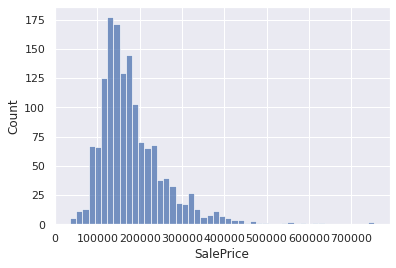

In [10]:
# Observe SalePrice train data
sns.set_theme(color_codes=True)

sns.histplot(train.SalePrice)

# Show any value counts, including NA
display(train.SalePrice.value_counts(dropna=False))
display(train.SalePrice.median())


In [11]:
# Save SalePrice train data and drop from df for independent variable preprocessing
y = train['SalePrice']
train = train.drop(columns=['SalePrice'])
display(y.describe())
display(train.info())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

None

In [12]:
# Observe info about test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## EDA

### Missing Values

In [13]:
# Show columns with the missing values in train set
def missing_columns (data_frame):
  missing = pd.DataFrame([data_frame.isna()[column].value_counts() 
                         for column in train.columns]).reset_index().rename(columns={'index':'Column', 0:'Present',1:'Missing'})

  top_na = missing[missing['Missing'] >= 1].sort_values(by='Missing',ascending=False)
  
  return top_na, len(top_na)

In [14]:
display(missing_columns(train)[0])
display(missing_columns(train)[1])

# Save list of missing train data
train_missing = missing_columns(train)[0]

,Column,Present,Missing
72,PoolQC,7.0,1453.0
74,MiscFeature,54.0,1406.0
6,Alley,91.0,1369.0
73,Fence,281.0,1179.0
57,FireplaceQu,770.0,690.0
3,LotFrontage,1201.0,259.0
58,GarageType,1379.0,81.0
59,GarageYrBlt,1379.0,81.0
60,GarageFinish,1379.0,81.0
63,GarageQual,1379.0,81.0


19

In [15]:
def missing_columns_graph (top_na):
  sns.set_theme(color_codes=True)

  # Create barplot of the columns with the most missing data in train set
  plt.figure(figsize=(11,10), frameon=False)
  sns.set_color_codes("pastel")
  ax = sns.barplot(x="Present", y="Column", data=top_na,
              label="Present", color="orange")

  sns.set_color_codes("muted")
  ax = sns.barplot(x="Missing", y="Column", data=top_na,
            label='Missing', color='silver')

  ax.legend()
  sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
  plt.xlabel('Rows')
  plt.ylabel('Data Columns with the Most NaNs')
  # ax.figure.savefig('figures/missing_data.png')
  plt.tight_layout()
  
  return ax


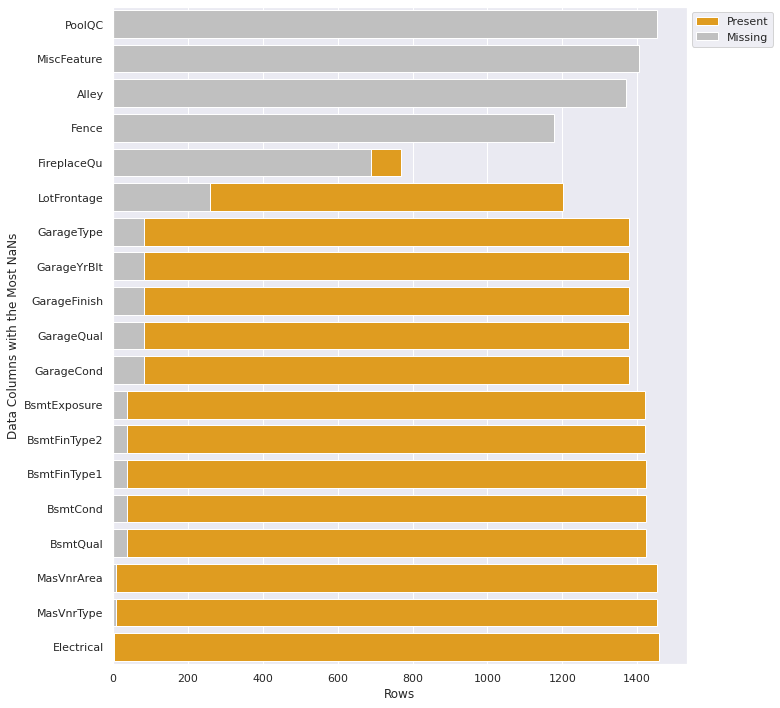

In [16]:
# Graph train missing data
missing_columns_graph(train_missing)

#### Numerical Missing Values

In [17]:
def num_missing (data_frame, missing_data):
    numerical_missing = list(data_frame[list(missing_data['Column'])].describe().columns)

    data_num_fill = pd.DataFrame()
    data_num_fill = data_frame[numerical_missing].copy()

    for feature in numerical_missing:
      data_num_fill[feature] = data_num_fill[feature].fillna(data_num_fill[feature].median())
    return data_num_fill, numerical_missing

In [18]:
train_num_miss = num_missing(train,train_missing)[1]
train[train_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   GarageYrBlt  1379 non-null   float64
 2   MasVnrArea   1452 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


In [19]:
df = num_missing(train,train_missing)[0]

train[train_num_miss] = df[train_num_miss]
train[train_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1460 non-null   float64
 1   GarageYrBlt  1460 non-null   float64
 2   MasVnrArea   1460 non-null   float64
dtypes: float64(3)
memory usage: 34.3 KB


#### Categorical Missing Values

In [20]:
def cat_missing (all_missing_data, numerical_missing):
  categorical_missing = []
  
  for element in list(all_missing_data['Column']):
    if element not in numerical_missing:
        categorical_missing.append(element)
  return categorical_missing


In [21]:
# Observe degree of missing data from categorical columns from train dataset
train_cat_miss = cat_missing(train_missing, train_num_miss)
train[train_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        7 non-null      object
 1   MiscFeature   54 non-null     object
 2   Alley         91 non-null     object
 3   Fence         281 non-null    object
 4   FireplaceQu   770 non-null    object
 5   GarageType    1379 non-null   object
 6   GarageFinish  1379 non-null   object
 7   GarageQual    1379 non-null   object
 8   GarageCond    1379 non-null   object
 9   BsmtExposure  1422 non-null   object
 10  BsmtFinType2  1422 non-null   object
 11  BsmtFinType1  1423 non-null   object
 12  BsmtCond      1423 non-null   object
 13  BsmtQual      1423 non-null   object
 14  MasVnrType    1452 non-null   object
 15  Electrical    1459 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


In [22]:
def fill_cat_na (data_frame, categorical_missing):
  remove = ['QC', 'Qu', 'Type', 'Finish', 'Qual', 'Feature',
            'Cond', 'Exposure', 'FinType1', 'FinType2']

  cat_fill = pd.DataFrame()
  cat_fill = data_frame[categorical_missing].copy()

  for feature in categorical_missing:
    for suffix in remove:
      if feature.endswith(suffix) is True:
        shrt_feat = feature[0:-len(suffix)]
        cat_fill[feature] = cat_fill[feature].fillna(f"No_{shrt_feat}")
  
  cat_fill['Alley'] = cat_fill['Alley'].fillna('No_Alley')
  cat_fill['Fence'] = cat_fill['Fence'].fillna('No_Fence')

  for feature in categorical_missing:
    cat_fill[feature] = cat_fill[feature].fillna('Unknown')
    
  return cat_fill

In [23]:
# apply fill_cat_na to train dataset
df = fill_cat_na(train,train_cat_miss)

train[train_cat_miss] = df[train_cat_miss]
train[train_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        1460 non-null   object
 1   MiscFeature   1460 non-null   object
 2   Alley         1460 non-null   object
 3   Fence         1460 non-null   object
 4   FireplaceQu   1460 non-null   object
 5   GarageType    1460 non-null   object
 6   GarageFinish  1460 non-null   object
 7   GarageQual    1460 non-null   object
 8   GarageCond    1460 non-null   object
 9   BsmtExposure  1460 non-null   object
 10  BsmtFinType2  1460 non-null   object
 11  BsmtFinType1  1460 non-null   object
 12  BsmtCond      1460 non-null   object
 13  BsmtQual      1460 non-null   object
 14  MasVnrType    1460 non-null   object
 15  Electrical    1460 non-null   object
dtypes: object(16)
memory usage: 182.6+ KB


### Impute Test Data

In [24]:
test_missing = missing_columns(test)[0]

test_num_miss = num_missing(test,test_missing)[1]
test[test_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1232 non-null   float64
 1   GarageYrBlt   1381 non-null   float64
 2   MasVnrArea    1444 non-null   float64
 3   BsmtFullBath  1457 non-null   float64
 4   BsmtHalfBath  1457 non-null   float64
 5   GarageCars    1458 non-null   float64
 6   GarageArea    1458 non-null   float64
 7   TotalBsmtSF   1458 non-null   float64
 8   BsmtUnfSF     1458 non-null   float64
 9   BsmtFinSF2    1458 non-null   float64
 10  BsmtFinSF1    1458 non-null   float64
dtypes: float64(11)
memory usage: 125.5 KB


In [25]:
df = num_missing(test,test_missing)[0]

test[test_num_miss] = df[test_num_miss]
test[test_num_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1459 non-null   float64
 1   GarageYrBlt   1459 non-null   float64
 2   MasVnrArea    1459 non-null   float64
 3   BsmtFullBath  1459 non-null   float64
 4   BsmtHalfBath  1459 non-null   float64
 5   GarageCars    1459 non-null   float64
 6   GarageArea    1459 non-null   float64
 7   TotalBsmtSF   1459 non-null   float64
 8   BsmtUnfSF     1459 non-null   float64
 9   BsmtFinSF2    1459 non-null   float64
 10  BsmtFinSF1    1459 non-null   float64
dtypes: float64(11)
memory usage: 125.5 KB


In [26]:
test_cat_miss = cat_missing(test_missing, test_num_miss)
test[test_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        3 non-null      object
 1   MiscFeature   51 non-null     object
 2   Alley         107 non-null    object
 3   Fence         290 non-null    object
 4   FireplaceQu   729 non-null    object
 5   GarageCond    1381 non-null   object
 6   GarageQual    1381 non-null   object
 7   GarageFinish  1381 non-null   object
 8   GarageType    1383 non-null   object
 9   BsmtCond      1414 non-null   object
 10  BsmtExposure  1415 non-null   object
 11  BsmtQual      1415 non-null   object
 12  BsmtFinType1  1417 non-null   object
 13  BsmtFinType2  1417 non-null   object
 14  MasVnrType    1443 non-null   object
 15  MSZoning      1455 non-null   object
 16  Functional    1457 non-null   object
 17  Utilities     1457 non-null   object
 18  KitchenQual   1458 non-null   object
 19  Exteri

In [27]:
df = fill_cat_na(test,test_cat_miss)

test[test_cat_miss] = df[test_cat_miss]
test[test_cat_miss].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PoolQC        1459 non-null   object
 1   MiscFeature   1459 non-null   object
 2   Alley         1459 non-null   object
 3   Fence         1459 non-null   object
 4   FireplaceQu   1459 non-null   object
 5   GarageCond    1459 non-null   object
 6   GarageQual    1459 non-null   object
 7   GarageFinish  1459 non-null   object
 8   GarageType    1459 non-null   object
 9   BsmtCond      1459 non-null   object
 10  BsmtExposure  1459 non-null   object
 11  BsmtQual      1459 non-null   object
 12  BsmtFinType1  1459 non-null   object
 13  BsmtFinType2  1459 non-null   object
 14  MasVnrType    1459 non-null   object
 15  MSZoning      1459 non-null   object
 16  Functional    1459 non-null   object
 17  Utilities     1459 non-null   object
 18  KitchenQual   1459 non-null   object
 19  Exteri

In [28]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

### Search for Features in Train Dataset

In [29]:
# Create feature combining MoSold values into seasons
# winter: 12, 1, 2 = 1
# Spring: 3, 4, 5 = 2
# Summer: 6, 7, 8 = 3
# Fall: 9, 10, 11 = 4

def seasons (data_frame):
  data_frame['Season'] = data_frame['MoSold'].replace({12: 1, 1: 1, 2: 1, 3: 2,
                                                4: 2, 5: 2, 6: 3, 7: 3,
                                                8: 3, 9: 4, 10: 4, 11: 4})
  return data_frame

seasons(train).head()
seasons(test).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Season
0,1461,20,RH,80.0,11622,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,No_Fireplace,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,No_Pool,MnPrv,No_Misc,0,6,2010,WD,Normal,3
1,1462,20,RL,81.0,14267,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,No_Fireplace,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,3
2,1463,60,RL,74.0,13830,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,No_Pool,MnPrv,No_Misc,0,3,2010,WD,Normal,2
3,1464,60,RL,78.0,9978,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,No_Pool,No_Fence,No_Misc,0,6,2010,WD,Normal,3
4,1465,120,RL,43.0,5005,Pave,No_Alley,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,No_Fireplace,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,No_Pool,No_Fence,No_Misc,0,1,2010,WD,Normal,1


In [30]:
# Create 30 year time periods feature
def builtyear_bin (data_frame):

  bins = [1870, 1900, 1930, 1960, 1990, 2010]
  group_names = [0, 1, 2, 3, 4]
  data_frame['YearBuilt_bin'] = pd.cut(data_frame['YearBuilt'], bins, labels=group_names).astype('float')
  return data_frame

builtyear_bin(train).head()
builtyear_bin(test).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Season,YearBuilt_bin
0,1461,20,RH,80.0,11622,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,No_Fireplace,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,No_Pool,MnPrv,No_Misc,0,6,2010,WD,Normal,3,3.0
1,1462,20,RL,81.0,14267,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,No_Fireplace,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,3,2.0
2,1463,60,RL,74.0,13830,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,No_Pool,MnPrv,No_Misc,0,3,2010,WD,Normal,2,4.0
3,1464,60,RL,78.0,9978,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,No_Pool,No_Fence,No_Misc,0,6,2010,WD,Normal,3,4.0
4,1465,120,RL,43.0,5005,Pave,No_Alley,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,No_Fireplace,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,No_Pool,No_Fence,No_Misc,0,1,2010,WD,Normal,1,4.0


In [31]:
display(train.GrLivArea.describe())
display(train.GarageArea.describe())
display(train.TotalBsmtSF.describe())

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [32]:
# Create feature combining structure area of AboveGround Living Area, Garage Area, and Bsmt Area

def combined_area (data_frame):
  data_frame['TotalStructureArea'] = data_frame['GrLivArea'] + data_frame['GarageArea'] + data_frame['TotalBsmtSF']
  return data_frame

combined_area(train).head()
combined_area(test).head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Season,YearBuilt_bin,TotalStructureArea
0,1461,20,RH,80.0,11622,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,No_Fireplace,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,No_Pool,MnPrv,No_Misc,0,6,2010,WD,Normal,3,3.0,2508.0
1,1462,20,RL,81.0,14267,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,No_Fireplace,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,No_Pool,No_Fence,Gar2,12500,6,2010,WD,Normal,3,2.0,2970.0
2,1463,60,RL,74.0,13830,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,No_Pool,MnPrv,No_Misc,0,3,2010,WD,Normal,2,4.0,3039.0
3,1464,60,RL,78.0,9978,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,No_Pool,No_Fence,No_Misc,0,6,2010,WD,Normal,3,4.0,3000.0
4,1465,120,RL,43.0,5005,Pave,No_Alley,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,No_Fireplace,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,No_Pool,No_Fence,No_Misc,0,1,2010,WD,Normal,1,4.0,3066.0


In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 83 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  1459 non-null   int64  
 1   MSSubClass          1459 non-null   int64  
 2   MSZoning            1459 non-null   object 
 3   LotFrontage         1459 non-null   float64
 4   LotArea             1459 non-null   int64  
 5   Street              1459 non-null   object 
 6   Alley               1459 non-null   object 
 7   LotShape            1459 non-null   object 
 8   LandContour         1459 non-null   object 
 9   Utilities           1459 non-null   object 
 10  LotConfig           1459 non-null   object 
 11  LandSlope           1459 non-null   object 
 12  Neighborhood        1459 non-null   object 
 13  Condition1          1459 non-null   object 
 14  Condition2          1459 non-null   object 
 15  BldgType            1459 non-null   object 
 16  HouseS

In [35]:
# add SalePrice information and train data into new df
train_corr = pd.DataFrame()
train_corr = train.copy()
train_corr['SalePrice'] = y.copy()
train_corr

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Season,YearBuilt_bin,TotalStructureArea,SalePrice
0,1,60,RL,65.0,8450,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,No_Fireplace,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,No_Pool,No_Fence,No_Misc,0,2,2008,WD,Normal,1,4.0,3114,208500
1,2,20,RL,80.0,9600,Pave,No_Alley,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,No_Pool,No_Fence,No_Misc,0,5,2007,WD,Normal,2,3.0,2984,181500
2,3,60,RL,68.0,11250,Pave,No_Alley,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,No_Pool,No_Fence,No_Misc,0,9,2008,WD,Normal,4,4.0,3314,223500
3,4,70,RL,60.0,9550,Pave,No_Alley,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,No_Pool,No_Fence,No_Misc,0,2,2006,WD,Abnorml,1,1.0,3115,140000
4,5,60,RL,84.0,14260,Pave,No_Alley,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,No_Pool,No_Fence,No_Misc,0,12,2008,WD,Normal,1,4.0,4179,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,No_Pool,No_Fence,No_Misc,0,8,2007,WD,Normal,3,4.0,3060,175000
1456,1457,20,RL,85.0,13175,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,No_Pool,MnPrv,No_Misc,0,2,2010,WD,Normal,1,3.0,4115,210000
1457,1458,70,RL,66.0,9042,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,No_Pool,GdPrv,Shed,2500,5,2010,WD,Normal,2,2.0,3744,266500
1458,1459,20,RL,68.0,9717,Pave,No_Alley,Reg,Lvl,Al

### Evaluating Features
* correlations
* distributions

In [97]:
def mask_corr_graph (data_frame, columnsof_interest):
  sns.set_theme(color_codes=True)

  features_corr = data_frame[columnsof_interest].corr()

  mask = np.zeros_like(features_corr)
  mask[np.triu_indices_from(mask)] = True

  with sns.axes_style("white"):
    if len(columnsof_interest) <=9:
      f, ax = plt.subplots(figsize=(10,8))
      ax = sns.heatmap(features_corr, annot=True, linewidths=0.5, cmap="YlGnBu", mask=mask)
    else:
      f, ax = plt.subplots(figsize=(15,17))
      ax = sns.heatmap(features_corr, annot=True, linewidths=0.5, cmap="YlGnBu", mask=mask)


  # ax.figure.savefig(f"figures/created_features_corr.png")
    
  return ax

In [124]:
def correlation (data_frame, dependent_variable, id_variable):
  dependent_corr = data_frame.corr()[dependent_variable].drop(labels=[id_variable, dependent_variable])

  corr_stats = dependent_corr.describe()

  # Create list of top 25% and bottom 25% of correlations with Sale Price
  dependent_corr_quarters = dependent_corr[(dependent_corr >= corr_stats[6]) 
                      | (dependent_corr <= corr_stats[4])]
  corr_quarters = pd.DataFrame(dependent_corr_quarters.sort_values(ascending=False))

  return dependent_corr, corr_quarters

In [125]:
def graph_corr (dependent_corr):
  sns.set_theme(color_codes=True)

  # Take out correlation between SalePrice and itself
  bx_corr = sns.boxplot(data=dependent_corr, orient='h', width=0.4,
            color='coral')
  plt.ylabel('Variable Correlation \nto Sale Price')
  # bx_corr.figure.savefig(f"figures/boxplot_all_corr.png")
    
  return bx_corr

In [166]:
def histplot (data_frame, features):
  sns.set_theme(color_codes=True)

  plotted = []
  for column in chosen_features:
    plotted = plotted + [f"{column}"]
    print(f"{column}")
    print(f"skew: {skew(data_frame[column])}")
    plt.figure(figsize=(8,9), frameon=False)
    hist = sns.histplot(data=data_frame, x=column, kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()
    # box.figure.savefig(f"figures/boxplot_{column}.png")
    plt.tight_layout()

  return hist, plotted

#### Correlations of New Features

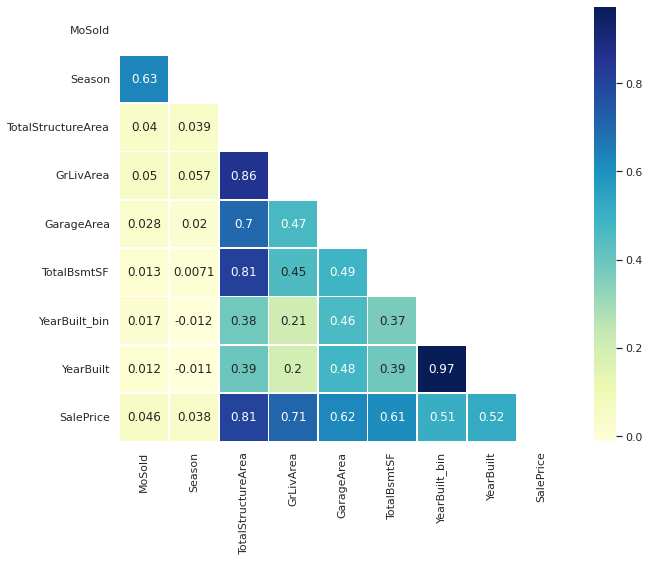

In [133]:
created_features = ['MoSold', 'Season', 'TotalStructureArea', 
                      'GrLivArea', 'GarageArea', 'TotalBsmtSF',
                      'YearBuilt_bin', 'YearBuilt', 'SalePrice']
mask_corr_graph(train_corr, created_features)

#### Highly Correlated Variables (All)

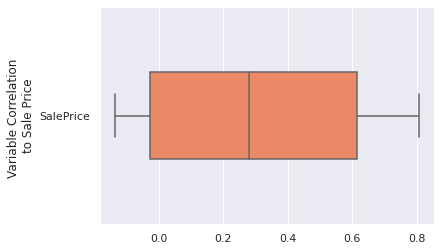

In [134]:

# Show trend of correlations so far
graph_corr(correlation(train_corr, 'SalePrice', 'Id')[1])

In [135]:
correlation(train_corr, 'SalePrice', 'Id')[1]

,SalePrice
TotalStructureArea,0.807518
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


MoSold
skew: 0.2118350601903434


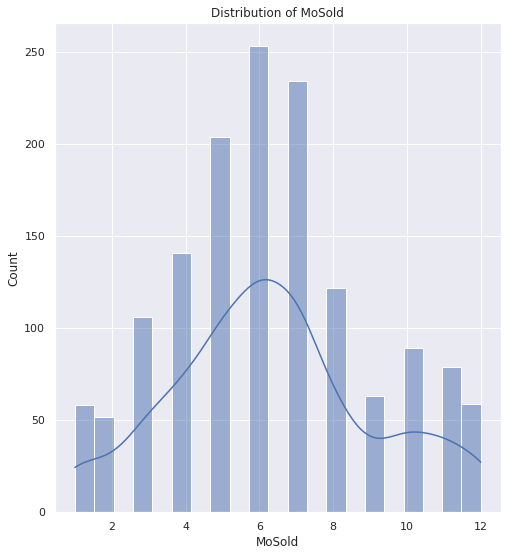

Season
skew: -0.17557128836557917


<Figure size 432x288 with 0 Axes>

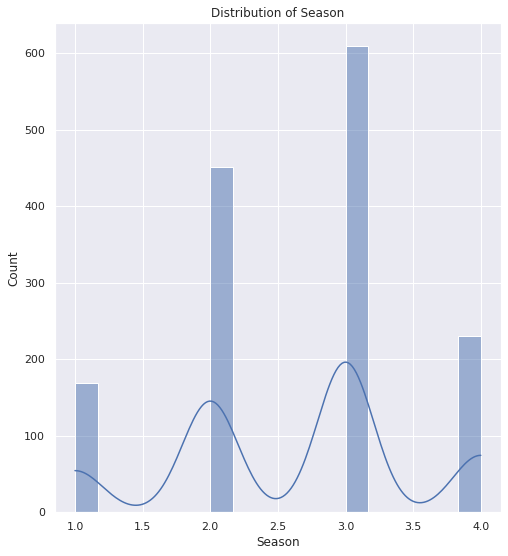

TotalStructureArea
skew: 1.509577490431419


<Figure size 432x288 with 0 Axes>

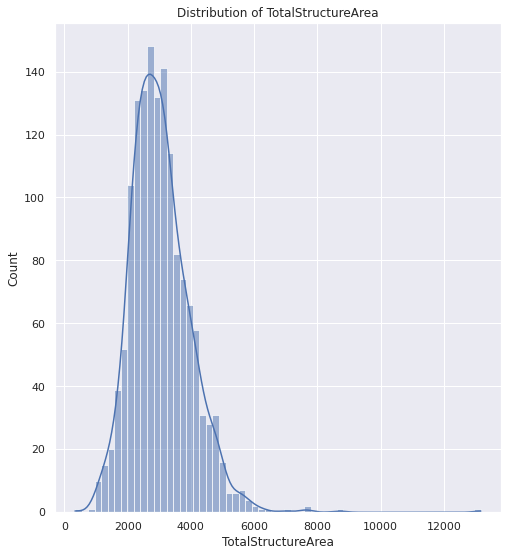

GrLivArea
skew: 1.365155954773434


<Figure size 432x288 with 0 Axes>

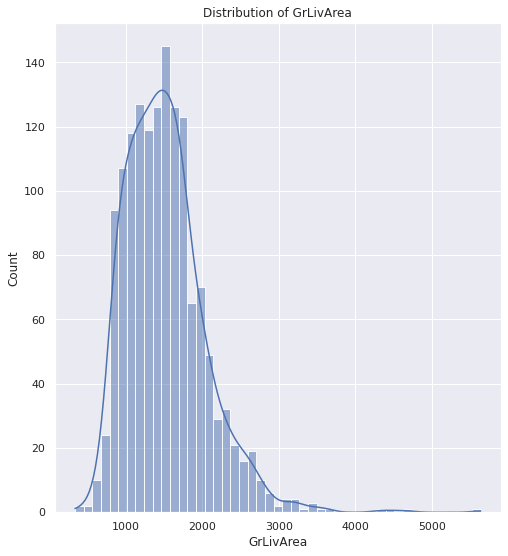

GarageArea
skew: 0.1797959420587727


<Figure size 432x288 with 0 Axes>

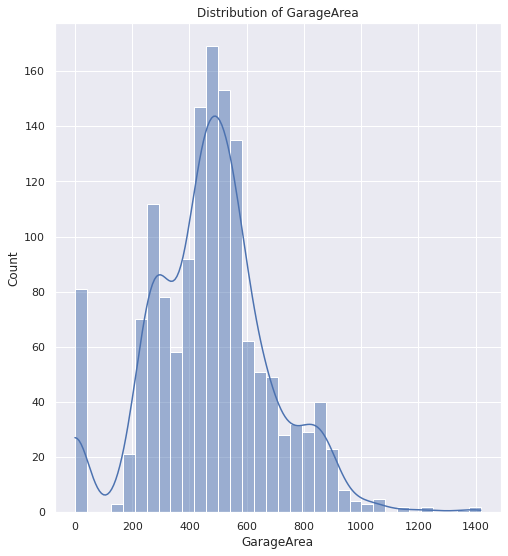

TotalBsmtSF
skew: 1.522688086978629


<Figure size 432x288 with 0 Axes>

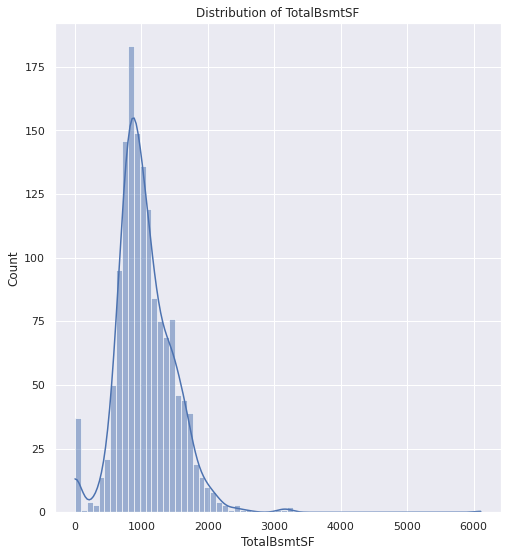

YearBuilt_bin
skew: -0.6120665844594654


<Figure size 432x288 with 0 Axes>

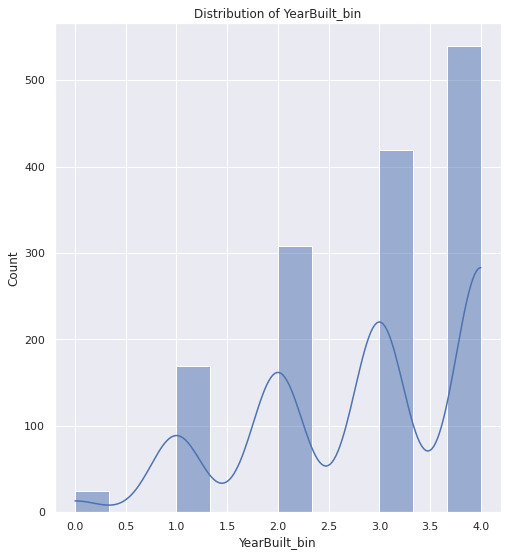

YearBuilt
skew: -0.612830724202899


<Figure size 432x288 with 0 Axes>

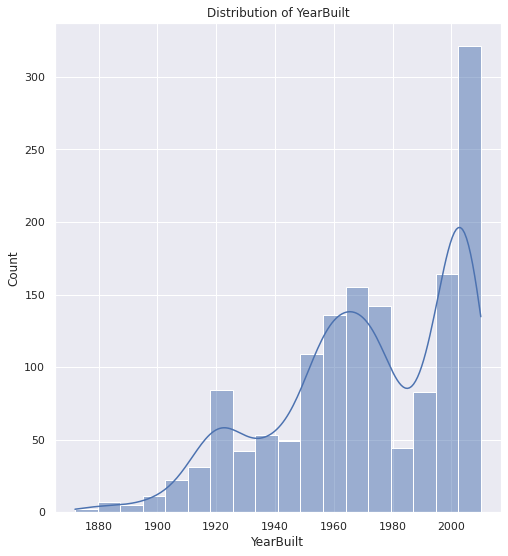

SalePrice
skew: 1.880940746034036


<Figure size 432x288 with 0 Axes>

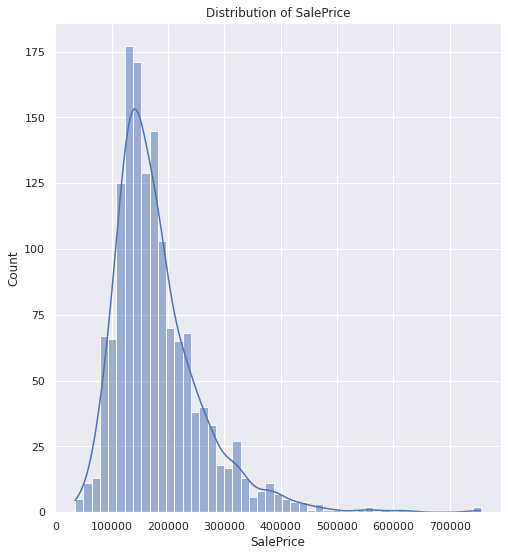

(<matplotlib.axes._subplots.AxesSubplot at 0x7f43a30e2a50>,
 ['MoSold',
  'Season',
  'TotalStructureArea',
  'GrLivArea',
  'GarageArea',
  'TotalBsmtSF',
  'YearBuilt_bin',
  'YearBuilt',
  'SalePrice'])

<Figure size 432x288 with 0 Axes>

In [167]:
histplot(train_corr, correlation(train_corr, 'SalePrice', 'Id')[1])

### Encoding categorical variables

In [49]:
# Concatenate train and test independent variable data so manipulations happend to both data sets
data = pd.concat([train, test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 83 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  2919 non-null   int64  
 1   MSSubClass          2919 non-null   int64  
 2   MSZoning            2919 non-null   object 
 3   LotFrontage         2919 non-null   float64
 4   LotArea             2919 non-null   int64  
 5   Street              2919 non-null   object 
 6   Alley               2919 non-null   object 
 7   LotShape            2919 non-null   object 
 8   LandContour         2919 non-null   object 
 9   Utilities           2919 non-null   object 
 10  LotConfig           2919 non-null   object 
 11  LandSlope           2919 non-null   object 
 12  Neighborhood        2919 non-null   object 
 13  Condition1          2919 non-null   object 
 14  Condition2          2919 non-null   object 
 15  BldgType            2919 non-null   object 
 16  HouseS

In [50]:
# chosen_features = ['TotalStructureArea', 'OverallQual', 'GarageCars', 'GarageArea',
#           'ExterQual_en', 'BsmtQual_en', 'KitchenQual_en', 'GarageFinish_en', 'YearBuilt_bin', 'YearBuilt']

In [51]:
# Differentiate numerical features (minus the target) and categorical features
# Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
categorical_features = data.select_dtypes(include = ["object"]).columns
numerical_features = data.select_dtypes(exclude = ["object"]).columns

In [52]:
data[categorical_features].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
unique,6,2,3,4,4,3,5,3,25,9,8,5,8,6,8,16,17,5,4,5,6,5,5,5,7,7,6,5,2,6,5,8,6,7,4,6,6,3,4,5,5,10,6
top,RL,Pave,No_Alley,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,No_Fireplace,Attchd,Unf,TA,TA,Y,No_Pool,No_Fence,No_Misc,WD,Normal
freq,2265,2907,2721,1859,2622,2916,2133,2778,443,2511,2889,2425,1471,2310,2876,1025,1014,1742,1798,2538,1308,1283,2606,1904,851,2493,2874,1493,2723,2671,1492,2717,1420,1723,1230,2604,2654,2641,2909,2348,2814,2525,2402


In [53]:
ordinal_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                    'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
                    'GarageQual', 'GarageCond', 'PoolQC']

In [54]:
display(data['BsmtCond'].unique())
display(data['BsmtExposure'].unique())

array(['TA', 'Gd', 'No_Bsmt', 'Fa', 'Po'], dtype=object)

array(['No', 'Gd', 'Mn', 'Av', 'No_Bsmt'], dtype=object)

In [55]:
data['BsmtExposure'] = data['BsmtExposure'].replace('Gd', 'Ge')
display(data['BsmtExposure'].unique())

array(['No', 'Ge', 'Mn', 'Av', 'No_Bsmt'], dtype=object)

In [56]:
[display(data[feature].value_counts())for feature in ordinal_features[:3]]

TA         1283
Gd         1209
Ex          258
Fa           88
No_Bsmt      81
Name: BsmtQual, dtype: int64

TA         2606
Gd          122
Fa          104
No_Bsmt      82
Po            5
Name: BsmtCond, dtype: int64

No         1904
Av          418
Ge          276
Mn          239
No_Bsmt      82
Name: BsmtExposure, dtype: int64

[None, None, None]

In [57]:
def ordinal_values (data_frame, ordinal_features):
  ordinal_all = []

  for feature in ordinal_features:
    ordinal_all = ordinal_all + list(data_frame[feature].unique())

  unique_ordinal =  set(ordinal_all)
  
  return unique_ordinal

ordinal_values(data, ordinal_features)

{'ALQ',
 'Av',
 'BLQ',
 'Ex',
 'Fa',
 'Fin',
 'GLQ',
 'Gd',
 'Ge',
 'LwQ',
 'Mn',
 'No',
 'No_Bsmt',
 'No_Fireplace',
 'No_Garage',
 'No_Kitchen',
 'No_Pool',
 'Po',
 'RFn',
 'Rec',
 'TA',
 'Unf'}

In [58]:
change_measures = {'ALQ': 5, 'Av': 3, 'BLQ': 4,  'Ex': 5, 'Fa': 2, 'Fin': 3,
 'GLQ': 6, 'Gd': 4, 'Ge': 4, 'LwQ': 2, 'Mn': 2, 'No': 1,
 'No_Bsmt': 0, 'No_Fireplace': 0, 'No_Garage': 0,
 'No_Kitchen': 0, 'No_Pool':0, 'Po': 1, 'RFn': 2,
 'Rec': 3, 'TA': 3, 'Unf': 1}

In [59]:
ordinal_encoded = pd.DataFrame()
ordinal_encoded = data[list(ordinal_features)].copy()

ordinal_encoded[ordinal_features] = ordinal_encoded[ordinal_features].replace(change_measures)

In [60]:
[display(ordinal_encoded[feature].value_counts())for feature in ordinal_features[:3]]
data[ordinal_features] = ordinal_encoded[ordinal_features]

3    1283
4    1209
5     258
2      88
0      81
Name: BsmtQual, dtype: int64

3    2606
4     122
2     104
0      82
1       5
Name: BsmtCond, dtype: int64

1    1904
3     418
4     276
2     239
0      82
Name: BsmtExposure, dtype: int64

In [61]:
set_difference = set(list(categorical_features)) - set(ordinal_features)
remaining_features = list(set_difference)

In [62]:
encoded_dummies = pd.get_dummies(data[remaining_features])

In [64]:
data = data[list(numerical_features) + ordinal_features]
data = pd.concat([data, encoded_dummies], axis=1)
display(data.shape)

(2919, 262)

In [65]:
train_corr_en = data.iloc[:1460]
train_corr_en['SalePrice'] = y.copy()

train_corr_en

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Season,YearBuilt_bin,TotalStructureArea,...,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_No_Sale,SaleType_Oth,SaleType_WD,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No_MasVnr,MasVnrType_None,MasVnrType_Stone,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,856.0,856,854,0,1710,1.0,0.0,2,1,3,1,8,0,2003.0,2.0,548.0,0,61,0,0,0,0,0,2,2008,1,4.0,3114.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,1262.0,1262,0,0,1262,0.0,1.0,2,0,3,1,6,1,1976.0,2.0,460.0,298,0,0,0,0,0,0,5,2007,2,3.0,2984.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,920.0,920,866,0,1786,1.0,0.0,2,1,3,1,6,1,2001.0,2.0,608.0,0,42,0,0,0,0,0,9,2008,4,4.0,3314.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,756.0,961,756,0,1717,1.0,0.0,1,0,3,1,7,1,1998.0,3.0,642.0,0,35,272,0,0,0,0,2,2006,1,1.0,3115.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,1145.0,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,1,2000.0,3.0,836.0,192,84,0,0,0,0,0,12,2008,1,4.0,4179.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,953.0,953.0,953,694,0,1647,0.0,0.0,2,1,3,1,7,1,1999.0,2.0,460.0,0,40,0,0,0,0,0,8,2007,3,4.0,3060.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,589.0,1542.0,2073,0,0,2073,1.0,0.0,2,0,3,1,7,2,1978.0,2.0,500.0,349,0,0,0,0,0,0,2,2010,1,3.0,4115.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,877.0,1152.0,1188,1152,0,2340,0.0,0.0,2,0,4,1,9,2,1941.0,1.0,252.0,0,60,0,0,0,0,2500,5,2010,2,2.0,3744.0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,0.0,1078.0,1078,0,0,1078,1.0,0.0,1,0,2,1,5,0,1950.0,1.0,240.0,366,0,112,0,0,0,0,4,2010,2,2.0,2396.0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,142125


In [66]:
# Observe stats for correlations
display(pd.DataFrame(train_corr_en.describe()))
corr_stats = train_corr_en.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Season,YearBuilt_bin,TotalStructureArea,...,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_No_Sale,SaleType_Oth,SaleType_WD,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_No_Garage,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No_MasVnr,MasVnrType_None,MasVnrType_Stone,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.589041,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,2.617808,2.875342,3045.873288,...,0.497260,0.005479,0.007534,0.304795,0.025342,0.044521,0.029452,0.002740,0.001370,0.006164,0.003425,0.003425,0.083562,0.0,0.002055,0.867808,0.004110,0.595890,0.013014,0.060274,0.006164,0.265068,0.055479,0.010274,0.304795,0.005479,0.591781,0.087671,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616,0.180137,0.064384,0.032192,0.002740,0.720548,180921.195890
std,421.610009,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,23.997022,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.885779,1.087442,959.534673,...,0.500164,0.073846,0.086502,0.460478,0.157217,0.206319,0.169128,0.052289,0.036999,0.078298,0.058440,0.058440,0.276824,0.0,0.045299,0.338815,0.063996,0.490887,0.113372,0.238075,0.078298,0.441521,0.228992,0.100873,0.460478,0.073846,0.491673,0.282913,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893,0.384433,0.245519,0.176570,0.052289,0.448884,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,1.0000

In [154]:
train_quarter = correlation(train_corr_en, 'SalePrice', 'Id')[1]

In [158]:
train_top = train_quarter.head(8) + train_quarter.tail(8)
model_features = list(train_top.index)

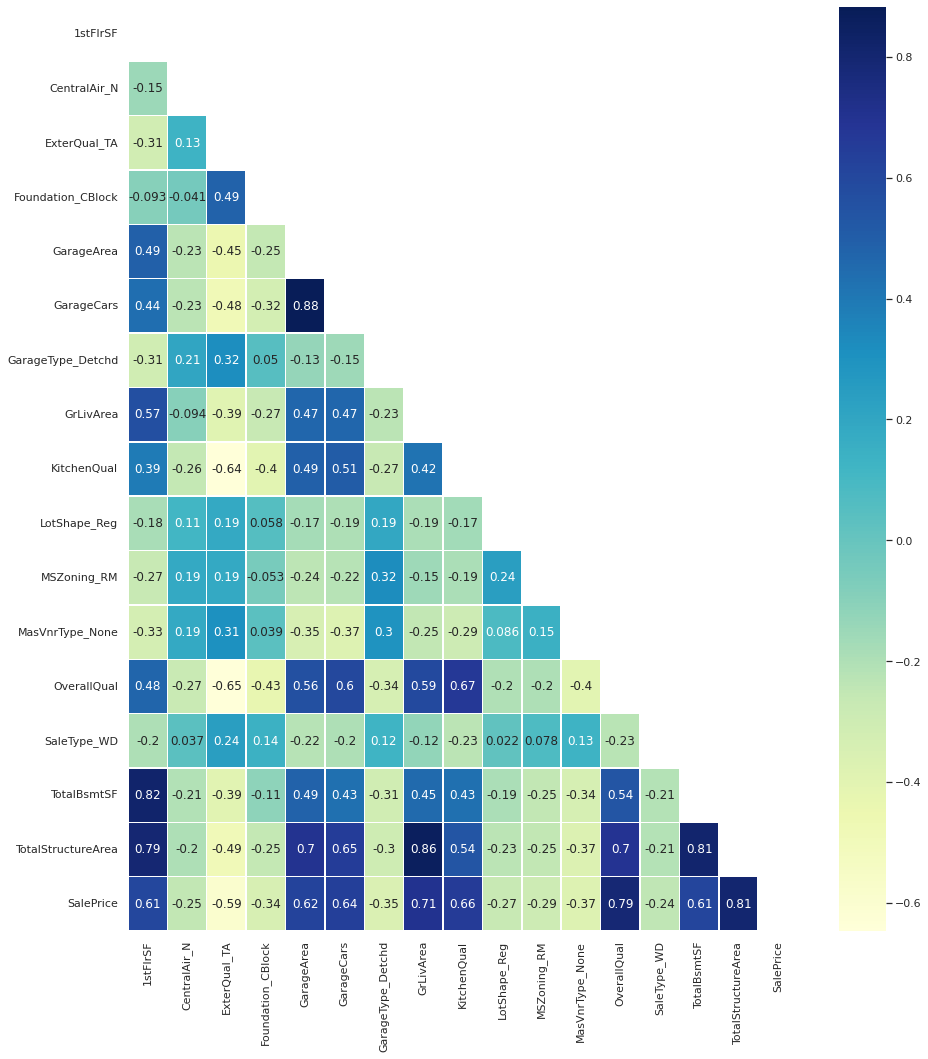

In [156]:
mask_corr_graph(train_corr_en, model_features + ['SalePrice'])

MoSold
skew: 0.2118350601903434


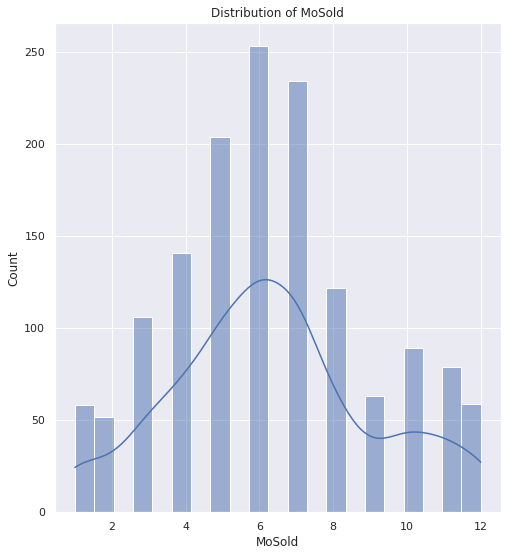

Season
skew: -0.17557128836557917


<Figure size 432x288 with 0 Axes>

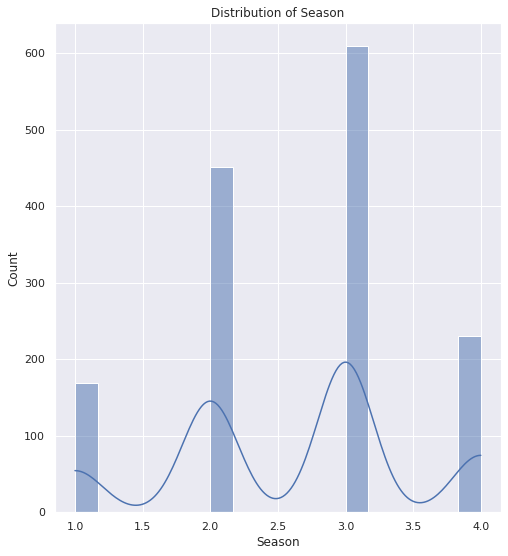

TotalStructureArea
skew: 1.509577490431419


<Figure size 432x288 with 0 Axes>

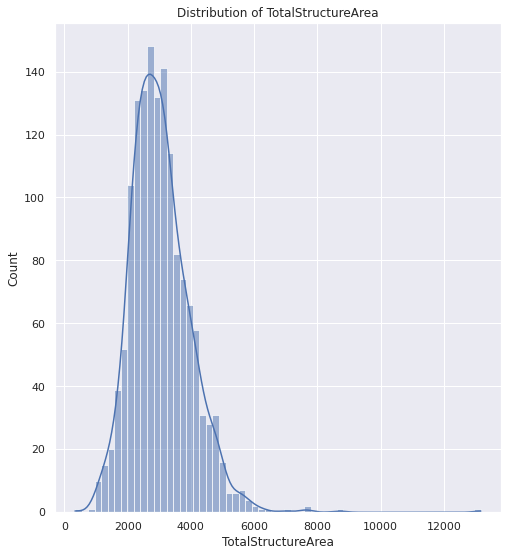

GrLivArea
skew: 1.365155954773434


<Figure size 432x288 with 0 Axes>

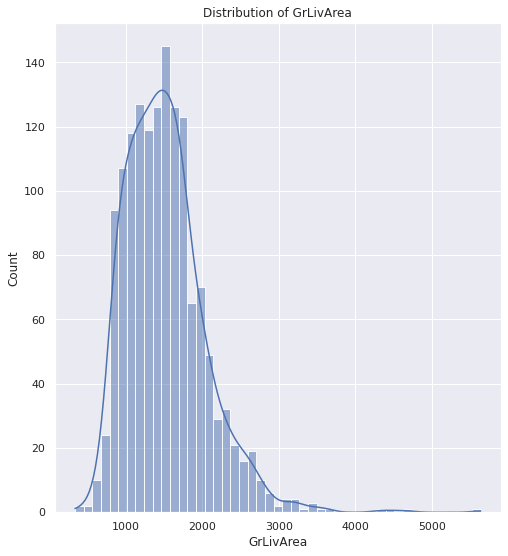

GarageArea
skew: 0.1797959420587727


<Figure size 432x288 with 0 Axes>

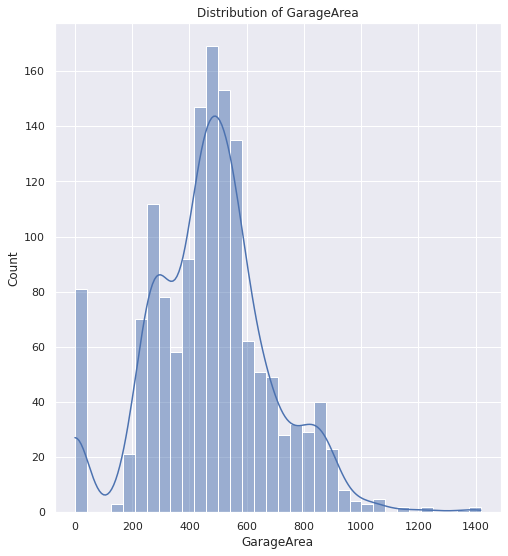

TotalBsmtSF
skew: 1.522688086978629


<Figure size 432x288 with 0 Axes>

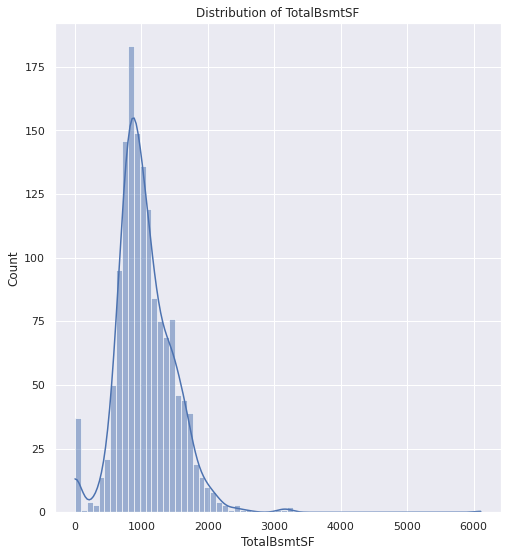

YearBuilt_bin
skew: -0.6120665844594654


<Figure size 432x288 with 0 Axes>

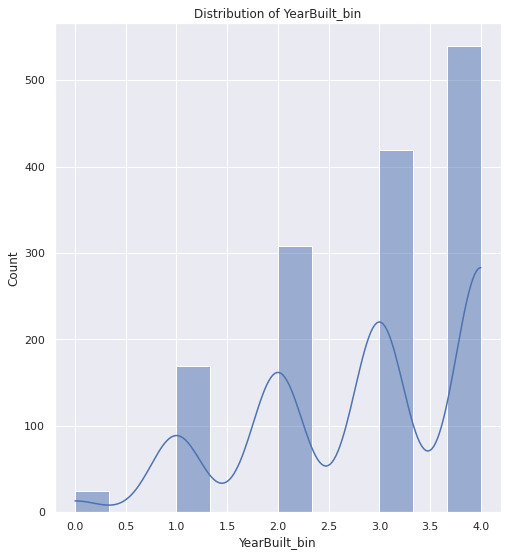

YearBuilt
skew: -0.612830724202899


<Figure size 432x288 with 0 Axes>

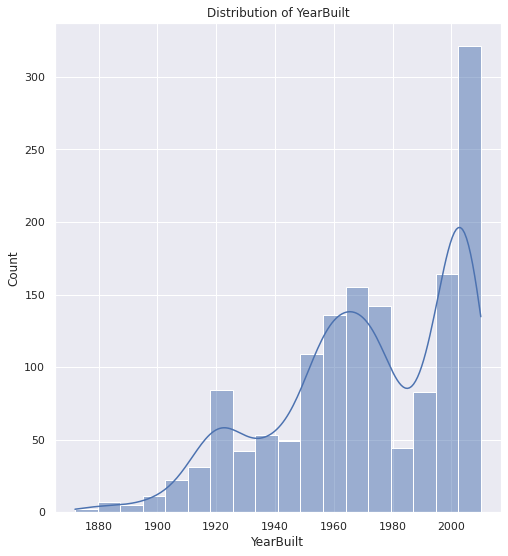

SalePrice
skew: 1.880940746034036


<Figure size 432x288 with 0 Axes>

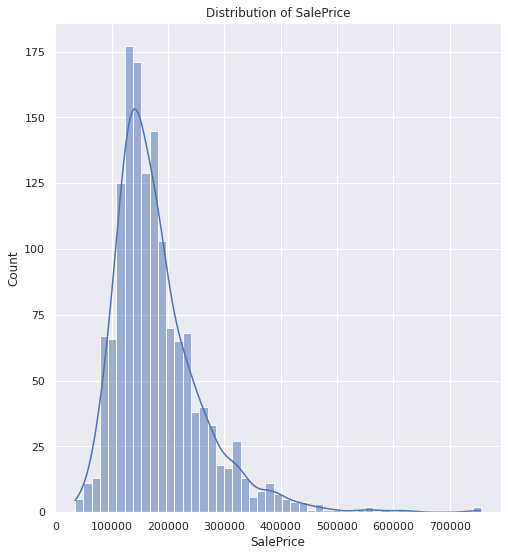

(<matplotlib.axes._subplots.AxesSubplot at 0x7f43a33646d0>,
 ['MoSold',
  'Season',
  'TotalStructureArea',
  'GrLivArea',
  'GarageArea',
  'TotalBsmtSF',
  'YearBuilt_bin',
  'YearBuilt',
  'SalePrice'])

<Figure size 432x288 with 0 Axes>

In [168]:
histplot(train_corr_en, model_features)

## Modeling

In [172]:
train = data[model_features].iloc[:1460]
print(train.shape)

id_test = test['Id']
test = data[model_features].iloc[1460:]
print(test.shape)

(1460, 16)
(1459, 16)


In [173]:
# Create training and test sets of preprocessed train data
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=10)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 16)
X_test : (438, 16)
y_train : (1022,)
y_test : (438,)


### Scaling

In [195]:
scaler = StandardScaler()

X_train_std  = scaler.fit_transform(X_train.values)
X_test_std = scaler.fit_transform(X_test.values)
testing_std  = scaler.fit_transform(test.values)


mm_scaler = MinMaxScaler()

X_train_mm = mm_scaler.fit_transform(X_train.values)
X_test_mm = mm_scaler.fit_transform(X_test.values)
testing_mm  = mm_scaler.fit_transform(test.values)


rb_scaler = RobustScaler()
X_train_rb = rb_scaler.fit_transform(X_train.values)
X_test_rb = rb_scaler.fit_transform(X_test.values)
testing_rb = rb_scaler.fit_transform(test.values)


### Linear Regression

In [196]:
# Differentiate numerical features (minus the target) and categorical features
# Inspired by JulienCS's script: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

def evaluating_model (y_true, y_pred):
  print(f"MSE: {mean_squared_error(y_true, y_pred)}")
  print(f"RMSE: {mean_squared_error(y_true, y_pred)**0.5}")
  print(f"MAE: {mean_absolute_error(y_true, y_pred)}")
  print(f"R_SQR: {r2_score(y_true, y_pred)}")
  print(f"EXV: {explained_variance_score(y_true, y_pred)}")
  print(f"ME: {max_error(y_true, y_pred)}")
  print(f"RMSLE: {mean_squared_log_error(y_true, y_pred)**0.5}")
  return

In [197]:
# Use standard scaler with linear regression to observe how train data predictions work
lr = LinearRegression()
lr.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_std = lr.predict(X_train_std)

evaluating_model(y_train, y_train_pred_std)

RMSE on Training set : 38991.14660745963
RMSE on Test set : 32422.67091339332
MSE: 1444183311.1922457
RMSE: 38002.41191282793
MAE: 23942.31525584213
R_SQR: 0.7776306670264702
EXV: 0.7776306670264702
ME: 418453.5251073643
RMSLE: 0.18998945878079257


In [198]:
# Use minmax scaler with linear regression to observe  how train data predictions work
lr.fit(X_train_mm, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_mm = lr.predict(X_train_mm)
y_test_pred_mm = lr.predict(X_test_mm)

evaluating_model(y_train, y_train_pred_mm)

RMSE on Training set : 38991.14660745963
RMSE on Test set : 32422.67091339332
MSE: 1444183311.1922457
RMSE: 38002.41191282793
MAE: 23942.315255842117
R_SQR: 0.7776306670264702
EXV: 0.7776306670264702
ME: 418453.5251073635
RMSLE: 0.1899894587807922


In [199]:
# Use robust scaler with linear regression to observe how train data predictions work
lr.fit(X_train_rb, y_train.values)

print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred_rb = lr.predict(X_train_rb)
y_test_pred_rb = lr.predict(X_test_rb)

evaluating_model(y_train, y_train_pred_rb)

RMSE on Training set : 38991.14660745963
RMSE on Test set : 32422.67091339332
MSE: 1444183311.1922457
RMSE: 38002.41191282793
MAE: 23942.31525584214
R_SQR: 0.7776306670264702
EXV: 0.7776306670264702
ME: 418453.52510736464
RMSLE: 0.1899894587807928


In [200]:
lr = LinearRegression()

In [208]:
# Use standard scaler and linear regression to predict test sale price data
lr.fit(X_train_std, y_train.values)

y_test_pred = lr.predict(testing_std)

pred_test_std_lr = pd.DataFrame()

pred_test_std_lr['Id'] = id_test
pred_test_std_lr['SalePrice'] = y_test_pred
pred_test_std_lr.to_csv('predictions/std_lg_houseprice_10_1_21.csv', index=False)

In [202]:
# Use minmax scaler and linear regression to predict test sale price data
lr.fit(X_train_mm, y_train.values)

y_test_pred = lr.predict(testing_mm)

pred_test_mm_lr = pd.DataFrame()

pred_test_mm_lr['Id'] = id_test
pred_test_mm_lr['SalePrice'] = y_test_pred
# pred_test_mm_lr.to_csv('predictions/mm_lg_houseprice_10_1_20.csv', index=False)

In [203]:
# Use minmax scaler and linear regression to predict test sale price data
lr.fit(X_train_rb, y_train.values)

y_test_pred = lr.predict(testing_rb)

pred_test_rb_lr = pd.DataFrame()

pred_test_rb_lr['Id'] = id_test
pred_test_rb_lr['SalePrice'] = y_test_pred
# pred_test_rb_lr.to_csv('predictions/rb_lg_houseprice_10_1_20.csv', index=False)

### Ridge

In [204]:
rd = Ridge()

In [205]:
rd.fit(X_train_std, y_train.values)

print("RMSE on Training set :", rmse_cv_train(rd).mean())
print("RMSE on Test set :", rmse_cv_test(rd).mean())

y_train_pred_std = rd.predict(X_train_std)
y_test_pred_std = rd.predict(X_test_std)

evaluating_model(y_train, y_train_pred_std)

RMSE on Training set : 38978.63384370248
RMSE on Test set : 32395.27182409763
MSE: 1444185341.131013
RMSE: 38002.43862084396
MAE: 23934.27367794877
R_SQR: 0.7776303544649511
EXV: 0.7776303544649511
ME: 418633.2625660924
RMSLE: 0.18986529351537357


In [206]:
lr.fit(X_train_std, y_train.values)

y_test_pred = lr.predict(testing_std)

pred_test_std_rd = pd.DataFrame()

pred_test_std_rd['Id'] = id_test
pred_test_std_rd['SalePrice'] = y_test_pred
# pred_test_std_rd.to_csv('predictions/std_rd_houseprice_10_1_21.csv', index=False)

## Conclusion

This home sale prices model could be helpful for listing agents deciding at what price to first list a house depending on a variety of home factors. Similarly, this model could help consumers on the otherside of the deal to determine if the sale price is appropriate. Cities or municipalities may also be interested in better determing home sale price in order to best determine property taxes to levy. 

The following features were used as predictors for home sale prices: 
* TotalStructureArea
* OverallQual
* GarageCars
* GarageArea
* ExterQual_en
* BsmtQual_en
* KitchenQual_en
* GarageFinish_en
* YearBuilt_bin
* YearBuilt

A linear regression model was implemented and used two versions of the trained data, standard scaled and minmax scaled. The standard scaled data performed better than the minmax scaled data. The standard scaled linear regression model had a root mean squared logarithmic error of 0.19060. There is significant room for imroving the model with either different features, models or scaling.

![standard_linear_reg](https://github.com/oimartin/Predicting_House_Prices/blob/main/predictions/std_lg_houseprice_10.png?raw=1)
